#Etivity -5 Regression And Dimensionality Reduction 

---



**Student Name: Riya Joe**

**Student Id:20023693**

# TASK 1 

In [92]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, RobustScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso, LassoCV
import pickle
from sklearn import svm
import matplotlib.pyplot as plt
%matplotlib inline

# imports necessary for dimensionality reduction
from sklearn.decomposition import PCA,NMF
from sklearn.feature_selection import RFE,SelectKBest, chi2
from sklearn import svm

# regression algorithms
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

# metrics for evaluating regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

**EXPLORATORY DATA ANALYSIS**

Import insurance data

In [93]:
df = pd.read_csv("./insurance-1.csv")
df.head()

,age,gender,bmi,children,smoker,region,insurance_cost
0,18,male,33.770,1,no,southeast,1725.55230
1,18,male,34.100,0,no,southeast,1137.01100
2,18,female,26.315,0,no,northeast,2198.18985
3,18,female,38.665,2,no,northeast,3393.35635
4,18,female,35.625,0,no,northeast,2211.13075


In [94]:
df.tail()

,age,gender,bmi,children,smoker,region,insurance_cost
1333,64,female,31.825,2,no,northeast,16069.08475
1334,64,female,26.885,0,yes,northwest,29330.98315
1335,64,male,26.410,0,no,northeast,14394.55790
1336,64,male,36.960,2,yes,southeast,49577.66240
1337,64,male,23.760,0,yes,southeast,26926.51440


Check for missing values and categories in data for hot-encoding 

In [95]:
df['gender'].value_counts()

male      676
female    662
Name: gender, dtype: int64

In [96]:
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [97]:
df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Find sum of null values 

In [98]:
df.isna().sum()

age               0
gender            0
bmi               0
children          0
smoker            0
region            0
insurance_cost    0
dtype: int64

In [99]:
df.describe()

,age,bmi,children,insurance_cost
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Children column has minimum =0 insists there would be null values but there is no null such values hence we neednt drop the children column 

Check for outliers in the data 

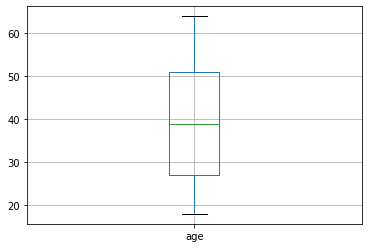

In [100]:
df.boxplot(column=['age'])
plt.show()

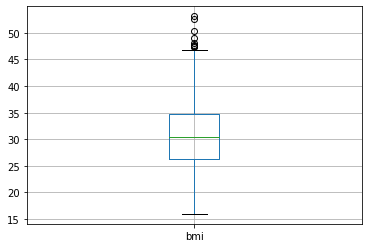

In [101]:
df.boxplot(column=['bmi'])
plt.show()

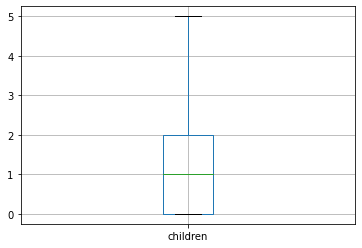

In [102]:
df.boxplot(column=['children'])
plt.show()

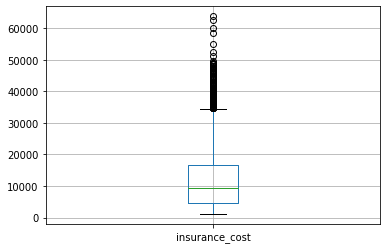

In [103]:
df.boxplot(column=['insurance_cost'])
plt.show()

Presence of outliers in insurance cost and  bmi

**DATA PREPARATION**

Hot encode values gender, smoker and region 

In [104]:
df = pd.get_dummies(df, columns=['gender', 'smoker', 'region'], 
                        drop_first=True)

In [105]:
df.head()

,age,bmi,children,insurance_cost,gender_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,18,33.770,1,1725.55230,1,0,0,1,0
1,18,34.100,0,1137.01100,1,0,0,1,0
2,18,26.315,0,2198.18985,0,0,0,0,0
3,18,38.665,2,3393.35635,0,0,0,0,0
4,18,35.625,0,2211.13075,0,0,0,0,0


Create transformation pipeline for data standard scaling 

In [106]:
preprocess_pipeline = make_pipeline(StandardScaler())

Make sure to drop our predictor column insurance from list of features 

In [107]:
y = df['insurance_cost']
X=df.drop('insurance_cost', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)


# TASK 2 
Grid Search for Best Parameters and Best Dimensionality Reduction Method

To the tranformation pipeline add random forest regressor model 

In [108]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

By use of good dimentionality reduction tenchiques removes redundant data and helps in improving computation time We use :

1. PCA Folding
2. Feature ranking with recursive feature elimination, base estimators being SVM and Linear Regression 

In [109]:
N_FEATURES_OPTIONS = [2, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7)],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
     
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
RF_best_params = search.best_params_
RF_best_model = search.best_estimator_

Best CV score = 0.855:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                  gamma='auto', kernel='linear', max_iter=-1, shrinking=True,
                  tol=0.001, verbose=False),
    n_features_to_select=8, step=1, verbose=0), 'reduce_dim__n_features_to_select': 8, 'regresson__max_depth': 4}


To the tranformation pipeline add Linear regressor model

In [110]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

By use of good dimentionality reduction tenchiques removes redundant data and helps in improving computation time We use :

1. PCA Folding
2. Feature ranking with recursive feature elimination, base estimators being SVM and Linear Regression 

In [111]:
N_FEATURES_OPTIONS = [2, 6, 8]
NORMALIZE_OPTIONS = [False, True]

param_grid = [
    {
        'reduce_dim': [PCA(iterated_power=7),NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
LR_best_params = search.best_params_
LR_best_model = search.best_estimator_

Best CV score = 0.745:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=6, step=1, verbose=0), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


Compare Regression Models on Test Set

Function to evaluate model 

In [112]:
def evaluate_model(X_test, y_test, model):
    
    # compute predictiond for the test set
    _predicted_values = model.predict(X_test)
        
    # compute metrics
    _mse = mean_squared_error(y_test, _predicted_values)
    _mae = mean_absolute_error(y_test, _predicted_values)
    _r2 = r2_score(y_test, _predicted_values)
            
    return _mse, _mae, _r2

Store evaluator parameters in RF_mse, RF_mae, RF_r2

In [113]:
RF_mse, RF_mae, RF_r2 = evaluate_model(X_test, y_test, RF_best_model)
LR_mse, LR_mae, LR_r2 = evaluate_model(X_test, y_test, LR_best_model)

Plot comparison for MSE,MAE,R2 predictors for Linear regressor, Random Forest Regression 

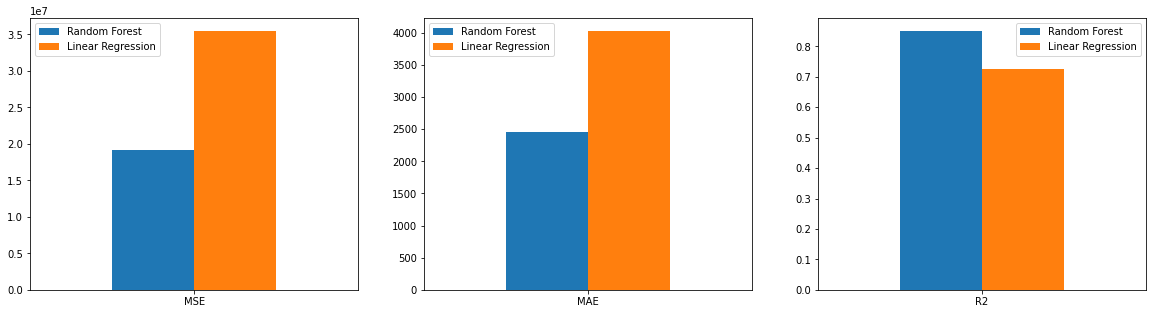

In [114]:
df_mse = pd.DataFrame({'Random Forest': RF_mse, 'Linear Regression': LR_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Random Forest': RF_mae, 'Linear Regression': LR_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Random Forest': RF_r2, 'Linear Regression': LR_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

CONCLUSIONS

---



We can conclude that Random Forest Regressor outperforms Linear Regressor due to lower MSE,MAE and a higher coefficient R2 

# TASK 3

The dimentional reduction techniques followed for random forest and linear regression models :

1. Non-Negative Matrix Factorization (NMF)
2. SelectKBest(chi2)

Recreate Pipelines for latest dimentionality reduction techiques 

In [115]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [116]:
N_FEATURES_OPTIONS = [2, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [SelectKBest(chi2)],
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)


SB_best_params = search.best_params_
SB_best_model = search.best_estimator_

Best CV score = 0.856:
Best parameters:  {'reduce_dim': RFE(estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                  gamma='auto', kernel='linear', max_iter=-1, shrinking=True,
                  tol=0.001, verbose=False),
    n_features_to_select=8, step=1, verbose=0), 'reduce_dim__n_features_to_select': 8, 'regresson__max_depth': 4}


NMF for Random Forest Regressor 

In [117]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', RandomForestRegressor(n_estimators=10))])

In [118]:
N_FEATURES_OPTIONS = [2, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]

param_grid = [
    {
        'reduce_dim': [NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__max_depth': MAX_DEPTH_OPTIONS
    }  
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

NMF_best_params = search.best_params_
NMF_best_model = search.best_estimator_

Best CV score = 0.853:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=8, step=1, verbose=0), 'reduce_dim__n_features_to_select': 8, 'regresson__max_depth': 4}


COMPARISON OF MODELS

In [119]:
SB_mse,SB_mae,SB_r2 = evaluate_model(X_test, y_test,SB_best_model)
NMF_mse,NMF_mae,NMF_r2 = evaluate_model(X_test, y_test,NMF_best_model)

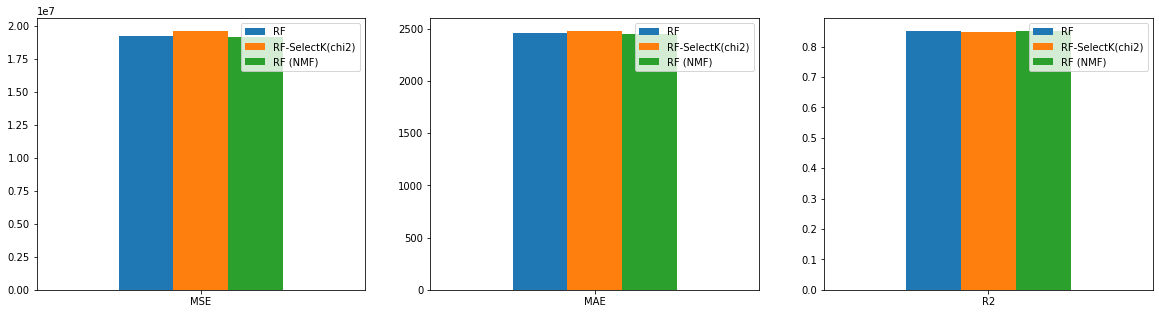

In [120]:
df_mse = pd.DataFrame({'RF': RF_mse, 'RF-SelectK(chi2)':SB_mse, 'RF (NMF)':NMF_mse}, index=['MSE'])
df_mae = pd.DataFrame({'RF': RF_mae, 'RF-SelectK(chi2)': SB_mae, 'RF (NMF)':NMF_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'RF': RF_r2, 'RF-SelectK(chi2)': SB_r2, 'RF (NMF)':NMF_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

The techniques involved are NMF and Kbest(Chi) they perform similarly to normmal RFE in case of Random Forest with select K best having lower MSE,MAE and higher R2 indicators suggest K best is sufficiently Good 

Reduction Techniques on Linear Regression Model

In [121]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                       ('reduce_dim', 'passthrough'),
                       ('regresson', LinearRegression())])

Apply NMF to Linear Regression Model 

In [122]:
NORMALIZE_OPTIONS = [False, True]
N_FEATURES_OPTIONS = [2, 6, 8]
param_grid = [
    {
        'reduce_dim': [NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    },
    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

NMFLR_best_params = search.best_params_
NMFLR_best_model = search.best_estimator_

Best CV score = 0.745:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=6, step=1, verbose=0), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


Apply Select K best to Linear Regression Model 

In [123]:
N_FEATURES_OPTIONS = [2, 6, 8]
NORMALIZE_OPTIONS = [False, True]
param_grid = [
    {   'reduce_dim': [SelectKBest(chi2)],
        'reduce_dim__k':N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
        
    },

    {
        'reduce_dim': [RFE(svm.SVR(kernel='linear', gamma='auto')),RFE(LinearRegression())],
        'reduce_dim__n_features_to_select': N_FEATURES_OPTIONS,
        'regresson__normalize': NORMALIZE_OPTIONS
    }
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)

print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

SBLR_best_params = search.best_params_
SBLR_best_model = search.best_estimator_

Best CV score = 0.745:
Best parameters:  {'reduce_dim': RFE(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                               normalize=False),
    n_features_to_select=6, step=1, verbose=0), 'reduce_dim__n_features_to_select': 6, 'regresson__normalize': False}


In [124]:
SB_mse,SB_mae,SB_r2 = evaluate_model(X_test, y_test,SBLR_best_model)
NMF_mse,NMF_mae,NMF_r2 = evaluate_model(X_test, y_test,NMFLR_best_model)

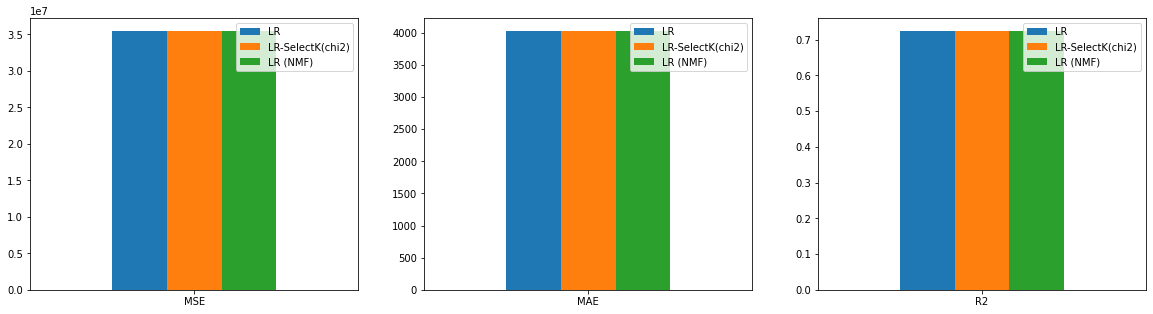

In [125]:
df_mse = pd.DataFrame({'LR': LR_mse, 'LR-SelectK(chi2)':SB_mse, 'LR (NMF)':NMF_mse}, index=['MSE'])
df_mae = pd.DataFrame({'LR': LR_mae, 'LR-SelectK(chi2)': SB_mae, 'LR (NMF)':NMF_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'LR': LR_r2, 'LR-SelectK(chi2)': SB_r2, 'LR (NMF)':NMF_r2}, index=['R2'])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

All techniques provide same result 

# TASK 4 

Experimented with Ridge Regression Model 

In [126]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                     ('reduce_dim', 'passthrough'),
                     ('regressor', Ridge())])

In [127]:
N_FEATURES_OPTIONS = [2, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
NORMALIZE_OPTIONS=[True,False]

param_grid = [

     {'regressor__alpha': np.arange(0, 0.2, 0.01) },  
     {   
        'reduce_dim': [PCA(iterated_power=7),NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regressor__normalize': NORMALIZE_OPTIONS
     } 
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
Ridge_best_params = search.best_params_
Ridge_best_model = search.best_estimator_

Best CV score = 0.744:
Best parameters:  {'reduce_dim': PCA(copy=True, iterated_power=7, n_components=8, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False), 'reduce_dim__n_components': 8, 'regressor__normalize': False}


Lasso Ridge  Model 

In [128]:
pipe = Pipeline(steps=[('preprocess', preprocess_pipeline), 
                     ('reduce_dim', 'passthrough'),
                     ('regressor', Lasso())])

In [129]:
N_FEATURES_OPTIONS = [2, 6, 8]
MAX_DEPTH_OPTIONS = [2, 4, 6, 8]
NORMALIZE_OPTIONS=[True,False]

param_grid = [

     {'regressor__alpha': [0.0005] },  
     {   
        'reduce_dim': [PCA(iterated_power=7),NMF()],
        'reduce_dim__n_components': N_FEATURES_OPTIONS,
        'regressor__normalize': NORMALIZE_OPTIONS
     } 
]

search = GridSearchCV(pipe, param_grid, n_jobs=-1, cv=5, refit=True)
search.fit(X_train, y_train)
print("Best CV score = %0.3f:" % search.best_score_)
print("Best parameters: ", search.best_params_)

# store the best params and best model for later use
Lasso_best_params = search.best_params_
Lasso_best_model = search.best_estimator_



Best CV score = 0.744:
Best parameters:  {'regressor__alpha': 0.0005}


Tried out two different regression models Ridge and Lasso Ridge Model , Both producced same results as Linear Regressor did on insurance data set .
1. Ridge Regression, which penalizes sum of squared coefficients (L2 penalty)
2. Lasso Regression, which penalizes the sum of absolute values of the coefficients (L1 penalty)

In [135]:
R_mse,R_mae,R_r2 = evaluate_model(X_test, y_test,Ridge_best_model)
L_mse,L_mae,L_r2 = evaluate_model(X_test, y_test,Lasso_best_model)

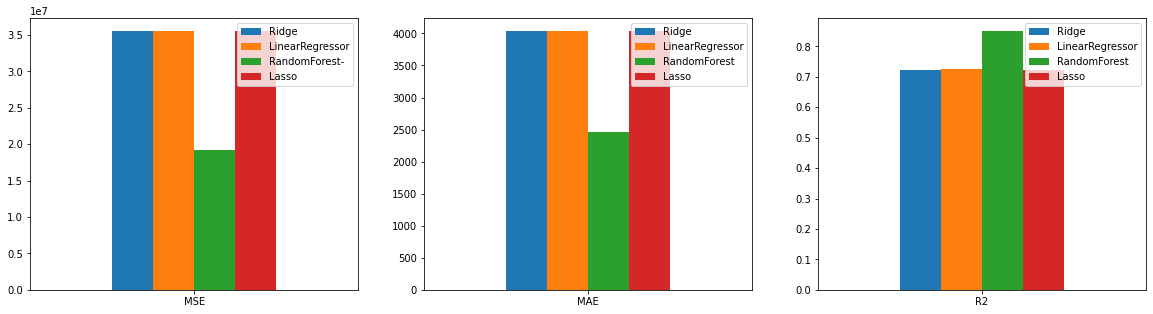

In [136]:
df_mse = pd.DataFrame({'Ridge': R_mse,'LinearRegressor':LR_mse, 'RandomForest-':RF_mse, 'Lasso':L_mse}, index=['MSE'])
df_mae = pd.DataFrame({'Ridge': R_mae, 'LinearRegressor':LR_mae,'RandomForest': RF_mae, 'Lasso':L_mae}, index=['MAE'])
df_r2 = pd.DataFrame({'Ridge': R_r2,'LinearRegressor':LR_r2, 'RandomForest': RF_r2, 'Lasso':L_r2}, index=['R2'])


fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

df_mse.plot.bar(rot=0, ax=axes[0])
df_mae.plot.bar(rot=0, ax=axes[1])
df_r2.plot.bar(rot=0, ax=axes[2])

plt.show()

This shows that Random Forest Regressor is better than linear regressor , ridge and lasso regressors as well. With lower MSE AND MAE and higher R2 rate.

# FINAL MODEL

The final model chosen is random forest for this insurance data set , as it outperfoms rest of the regressors 

In [133]:
# function to remove the string 'regresson__' from the names of the best parameters
def transform(dict, prefix):
    dict_prefix = {key:value for key,value in dict.items() if prefix in key}
    return {key.replace(prefix,''):value for key,value in dict_prefix.items()}

pipe = make_pipeline(preprocess_pipeline, 
                     RF_best_params.get('reduce_dim'),
                     RandomForestRegressor(n_estimators=10, **transform(RF_best_params, 'regresson__')))

final_model =pipe.fit(X, y)

Save the data 

In [134]:
filename = 'final_model.sav'
pickle.dump(final_model, open(filename, 'wb'))